In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
#######
import statistics as stat
import scipy as sp
from bisect import bisect  # to compute time index
import pygsp
from pygsp import graphs
from pygsp import filters
#######
from matrixprofile.matrixProfile import stomp
from matrixprofile.motifs import motifs
from matrixprofile.discords import discords

In [2]:
signal = pd.read_csv('traffic_sum_node.csv', index_col=0) # read matrix of signals
G1 = nx.read_gml('/home/manuelherrera/Data/BT_data/graph_anonymous.gml')

G2 = G1.to_undirected()
#for c in nx.connected_components(G2):
#    G2.subgraph(c)
    
largest_cc = max(nx.connected_components(G2), key=len)

Gc = G2.subgraph(largest_cc) 
pos = nx.spring_layout(Gc) # layout by default that it is saved for future use

nnodes = len(Gc) # 222 nodes - 206 now
nedges = Gc.number_of_edges() # 730 edges - 722 now

node_names = list(Gc.nodes); link_names = list(Gc.edges)

# initializing substring 
subs = 'core-aln1'
node_names1 = [i for i in node_names if subs in i]

G = Gc.subgraph(node_names1)

pos = nx.spring_layout(G) # layout by default that it is saved for future use

# Fixing node classifications
G.nodes['core-aln1.tan-chachalaca']['nodeType'] = 'regional'
G.nodes['core-aln1.whimsical-angelfish']['nodeType'] = 'metro'

nodes_super = [x for x,y in G.nodes(data=True) if y['nodeType']=='super']
nodes_regional = [x for x,y in G.nodes(data=True) if y['nodeType']=='regional']
nodes_metro = [x for x,y in G.nodes(data=True) if y['nodeType']=='metro']
nodes_inner = [x for x,y in G.nodes(data=True) if y['nodeType']=='super' or y['nodeType']=='regional']
nodes_outer = [x for x,y in G.nodes(data=True) if y['nodeType']=='regional' or y['nodeType']=='metro']
df_inner = signal[nodes_inner]
df_outer = signal[nodes_outer]

In [3]:
Network2 = G.subgraph(nodes_outer)
remove = [node for node,degree in dict(Network2.degree()).items() if degree == 0]
Network = Network2.copy()
Network.remove_nodes_from(remove)
#df_outer

In [4]:
# Also remove those nodes from the BT_outer dataframe !! IMPORTANT -- done cell above ??
remove_list = []
for node in remove:
    if node in df_outer.columns:
        df_outer.drop(node, axis=1, inplace=True)
        
print("Number of columns:"); print(len(df_outer.columns)); print("Number of network nodes:"); print(len(Network))

Number of columns:
92
Number of network nodes:
92


/home/manuelherrera/anaconda3/envs/simulator/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


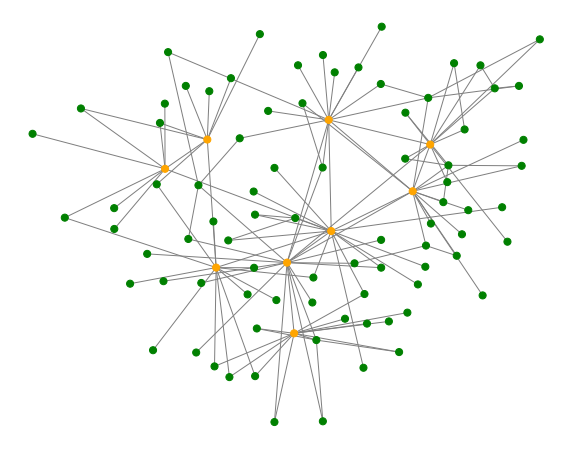

In [5]:
def color_map(Graph):
    color_map_n = []
    for i in Graph.nodes():
        if Graph.nodes[i]['nodeType'] == 'super':
            color_map_n.append('red')
        elif Graph.nodes[i]['nodeType'] == 'regional':
            color_map_n.append('orange')
        elif Graph.nodes[i]['nodeType'] == 'metro':
            color_map_n.append('green')
        else: color_map_n.append('blue')
    return color_map_n

color_map_n = color_map(Network)
f_outer = plt.figure(figsize=(10, 8))
plt.axis('off')
nx.draw_networkx(Network, pos, node_size=50, node_color = color_map_n, edge_color = "gray", with_labels=False)
plt.show()

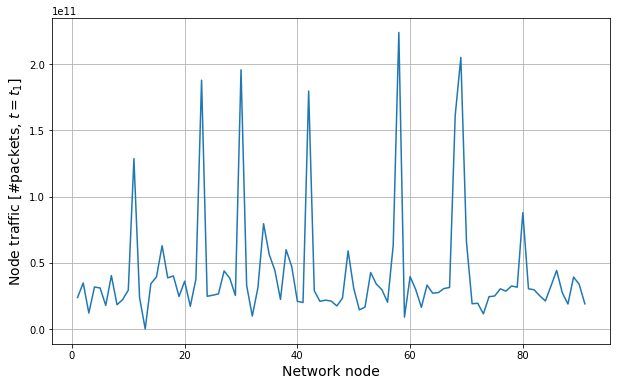

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Network node',  fontsize=14)
plt.ylabel('Node traffic [#packets, $t = t_1$]',  fontsize=14)
aux = [i for i in range(1, 92)]
ax.plot(aux, list(df_outer.loc[0][0:91])) #, color = 'grey', markersize=10)
#fig.savefig("Traffic_outer_t1.pdf", bbox_inches='tight')

In [7]:
peso = df_outer.loc[0] # t0 for testing purposes... This should vary from 0 up to T = 719 in this specific case
for i in Network.nodes():
    Network.nodes[i]['weight'] = peso[i]

A = nx.adjacency_matrix(Network, weight='weight')
Network1 = graphs.Graph(W = A, gtype = 'Outer core')
#Network1.set_coordinates('spring')
#Network1.plot(vertex_size=50)
#plt.axis('off'); plt.title('')
eig_val, U = sp.linalg.eigh(Network1.L.toarray()) 

In [8]:
T = 720
myInt = 10e9
eig_val = []; U = []; Networks = []
for t in range(T):
    peso = df_outer.loc[t]
    zpeso = [x / myInt for x in peso]
    for i in Network.nodes():
        Network.nodes[i]['weight'] = peso[i]
    A = nx.adjacency_matrix(Network, weight='weight')
    Network1 = graphs.Graph(W = A, gtype = 'Outer core')
    eig_val_aux, U_aux = sp.linalg.eigh(Network1.L.toarray())
    eig_val.append(eig_val_aux) # where eig_val[t] is the array of eig_val at time t
    U.append(U_aux) # where U[t] is the array of eigenvec at time t
    Networks.append(Network1)

In [9]:
eig_val[0][1:10] # Working with the first K eigenvectors corresponding to the lowest eigenvalues

array([0.11513618, 0.27457461, 0.40095915, 0.43489753, 0.47863107,
       0.50251131, 0.55842401, 0.60733471, 0.87849991])

In [10]:
tau = 1; nlambdas = 10;
spectra = []
for t in range(T):
    peso = df_outer.loc[t]
    zpeso = [x / myInt for x in peso]
    x0 = np.array(zpeso)
    Networks[t].compute_fourier_basis()
    g = filters.Heat(Networks[t], tau)
    x = g.filter(x0).squeeze()
    x_hat = Networks[t].gft(x).squeeze()
    spectra.extend(np.abs(x_hat).tolist()[1:nlambdas])  # Taking the TOP 10 eigenvectors; out the 1st because it is == 1 ...

In [11]:
#fig, ax = plt.subplots(figsize=(18, 3))
#plt.grid(True)
#plt.xlabel('$\lambda_n(t)$ (N nodes) x t (T time units)',  fontsize=14)
#plt.ylabel('GFT', fontsize=14)
#ax.plot(spectra, color = 'steelblue', markersize=10)
#fig.savefig("GSP_MP_outer1a.pdf", bbox_inches='tight')

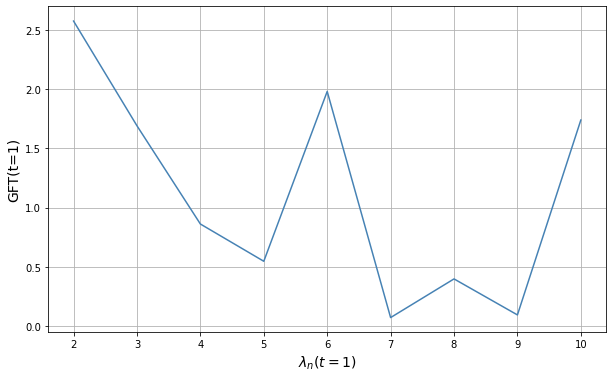

In [12]:
fg, ax = plt.subplots(figsize=(10, 6))
plt.grid(True)
plt.xlabel('$\lambda_n(t=1)$',  fontsize=14)
plt.ylabel('GFT(t=1)',  fontsize=14)
ax.plot([i for i in range(2, nlambdas + 1)], spectra[1:nlambdas], color = 'steelblue', markersize=4)

In [13]:
window_size = nlambdas # could take other length
mp, mpi = stomp(spectra, window_size)

In [14]:
#fig, ax = plt.subplots(figsize=(18, 3))
#plt.grid(True)
#plt.xlabel('$\lambda_k(t)$ (N nodes) x t (T time units)',  fontsize=14)
#plt.ylabel('Matrix Profile',  fontsize=14)
#ax.plot(mp, color = 'steelblue', markersize=4)
#fig.savefig("GSP_MP_outer1b.pdf", bbox_inches='tight')

In [15]:
top_discords = discords(mp, window_size, k=5)

data = np.array(spectra, dtype=np.float32)
original_motifs = motifs(data, (mp,mpi), max_motifs=5, ex_zone=window_size, n_neighbors=5)
top_motifs = [item[0] for item in original_motifs[0]]

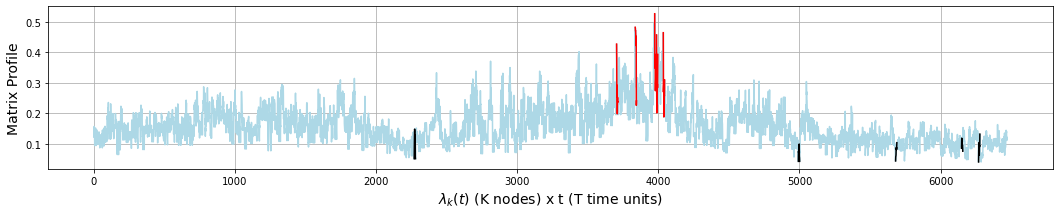

In [16]:
fig, ax = plt.subplots(figsize=(18, 3)) # top_motifs and top_discords
plt.grid(True)
plt.xlabel('$\lambda_k(t)$ (K nodes) x t (T time units)',  fontsize=14)
plt.ylabel('Matrix Profile',  fontsize=14)
ax.plot(mp, color = 'lightblue', markersize=4)
for start_index in top_motifs:
    aux = [i for i in range(start_index, start_index+window_size)]
    ax.plot(aux, mp[start_index:(start_index+window_size)], color = 'black')
for start_index in top_discords:
    aux = [i for i in range(start_index, start_index+window_size)]
    ax.plot(aux, mp[start_index:(start_index+window_size)], color = 'red')
#fig.savefig("GSP_MP_outer1br.pdf", bbox_inches='tight')

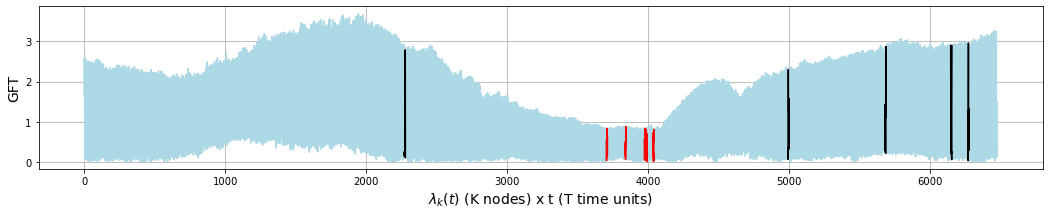

In [17]:
fig, ax = plt.subplots(figsize=(18, 3))
plt.grid(True)
plt.xlabel('$\lambda_k(t)$ (K nodes) x t (T time units)',  fontsize=14)
plt.ylabel('GFT',  fontsize=14)
ax.plot(spectra, color = 'lightblue', markersize=10)
for start_index in top_motifs:
    aux = [i for i in range(start_index, start_index+window_size)]
    ax.plot(aux, spectra[start_index:(start_index+window_size)], color = 'black')
for start_index in top_discords:
    aux = [i for i in range(start_index, start_index+window_size)]
    ax.plot(aux, spectra[start_index:(start_index+window_size)], color = 'red')
#fig.savefig("GSP_MP_outer1ar.pdf", bbox_inches='tight')

In [18]:
nlambdas = 10 # defined above. To delete in the next session (today 23-10-20)
ind_left = [] # len(Network spectrum) = nlambdas; time from 0 up to 719 -- or is it 1 to 720 ? df_outer.shape[0] = 720
for i in range(0,df_outer.shape[0]):
    if i > 0:
        ind_left.append((nlambdas - 1)*i + 1)
    else: ind_left.append(0)

ind_right = []
for i in range(1,df_outer.shape[0]+1):
    ind_right.append((nlambdas - 1)*i)

In [19]:
top_discords

array([3974, 3836, 4035, 3987, 3704])

In [20]:
# time to event
discords_t = []; motifs_t = []
for i in top_discords:
    discords_t.append(bisect(ind_left, i))
samp_discords = discords_t # number of network with a discord
discords_t = [h*2 for h in discords_t] # minutes from 14:00

for j in top_motifs:
    motifs_t.append(bisect(ind_left, j))
samp_motifs = motifs_t  # number of network with a motif
motifs_t = [h*2 for h in motifs_t] # minutes from 14:00

In [21]:
for i in discords_t:
    hours = i // 60
    minutes = i % 60
    print("14:00 plus ""%d:%02d" % (hours, minutes))

14:00 plus 14:44
14:00 plus 14:14
14:00 plus 14:58
14:00 plus 14:46
14:00 plus 13:44


In [22]:
for i in motifs_t:
    hours = i // 60
    minutes = i % 60
    print("14:00 plus ""%d:%02d" % (hours, minutes))

14:00 plus 23:14
14:00 plus 18:30
14:00 plus 21:04
14:00 plus 22:48
14:00 plus 8:26


In [ ]:
# TO-DO next is to check one by one which nodes are involved in the discord / motif. That's is,
# check which eigenvalues intervend in such a distance
# go to the U matrix of the time samp_* 
# take the eigenvector corresponding to the eigenvalue
# see the combination of nodes in such an eigenvector

In [23]:
samp_discords

[442, 427, 449, 443, 412]

In [24]:
samp_motifs

[697, 555, 632, 684, 253]

In [25]:
# For each time, the network spectrum is defined by 2:11 top eigenvectors => size = 9
np_array = np.array(spectra)
reshaped_array = np.reshape(np_array, (720, 9))
a_dataframe = pd.DataFrame(reshaped_array)
a_dataframe

,0,1,2,3,4,5,6,7,8
0,1.682496,2.573253,1.689553,0.860814,0.546399,1.979493,0.071345,0.397613,0.093808
1,1.738170,2.575748,1.706459,0.802766,0.566318,2.021306,0.061294,0.348030,0.087546
2,1.701833,2.472411,1.717444,0.794233,0.543508,1.982097,0.027312,0.271056,0.120459
3,1.769434,2.508600,1.679449,0.854410,0.525463,2.068140,0.005929,0.263090,0.123653
4,1.774818,2.500272,1.768566,0.904632,0.554938,2.079419,0.071521,0.277251,0.118211
...,...,...,...,...,...,...,...,...,...
715,2.116758,3.180679,0.922551,1.274751,0.205208,1.440148,0.182158,0.376511,0.126848
716,2.119763,3.213298,0.885198,1.240660,0.187970,1.423462,0.188001,0.452261,0.100349
717,2.173930,3.265592,0.889725,1.238507,0.308745,1.488212,0.148237,0.400819,0.031000
718,2.020379,3.196422,0.882922,1.224645,0.302432,1.488625,0.204042,0.456523,0.120093


In [26]:
df_gft = a_dataframe.copy()
for i in top_discords:
    df_gft.drop(bisect(ind_left, i) - 1, axis=0, inplace=True)

mean_gsignal = df_gft.mean(axis = 0)

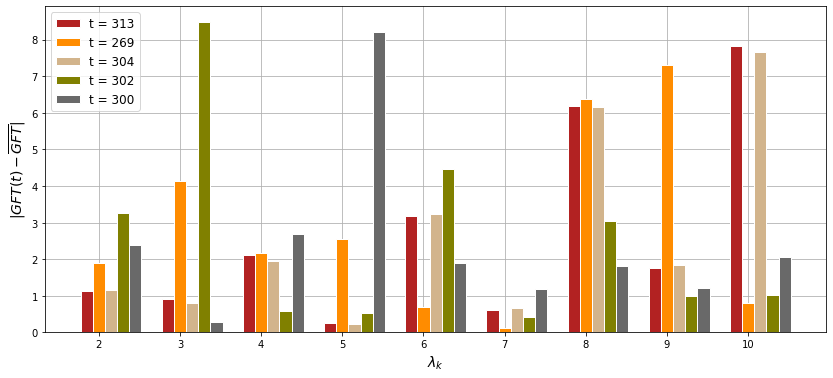

In [40]:
barWidth = 0.15
 
# set height of bar
bars = []
for i in samp_discords:
    aux = [abs(x - y) for x,y in zip(list(mean_gsignal),list(spectra[i:(i + 9)]))]
    bars.append(aux)

bars1 = bars[0]; bars2 = bars[1]; bars3 = bars[2]
bars4 = bars[3]; bars5 = bars[4]
    
# Set position of bar on X-axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]; r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]; r5 = [x + barWidth for x in r4]
 
# Make the plot
fg, ax = plt.subplots(figsize=(14, 6))
xaxis = [i for i in range(2, 11)]
plt.grid(True)
ax.set_axisbelow(True)

# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(bars1))], [i for i in range(2, 11)])

plt.xlabel('$\lambda_k$',  fontsize=14)
plt.ylabel('$| GFT(t) - \overline{GFT} |$',  fontsize=14)
plt.bar(r1, bars1, color='firebrick', width=barWidth, edgecolor='white', label='t = 313')
plt.bar(r2, bars2, color='darkorange', width=barWidth, edgecolor='white', label='t = 269')
plt.bar(r3, bars3, color='tan', width=barWidth, edgecolor='white', label='t = 304')
plt.bar(r4, bars4, color='olive', width=barWidth, edgecolor='white', label='t = 302')
plt.bar(r5, bars5, color='dimgrey', width=barWidth, edgecolor='white', label='t = 300')
 
# Create legend & show graphic
plt.legend(fontsize=12)
plt.show()
#fg.savefig("Outer_discords_dev.pdf", bbox_inches='tight')

In [41]:
discords_find1 = []
for i in samp_discords:
    aux = [abs(x - y) for x,y in zip(list(mean_gsignal),list(spectra[i:(i + 9)]))]
    discords_find1.append(aux)

discords_find1[0]

[1.1400828863590418,
 0.9139859686188551,
 2.1200931281945485,
 0.25134150333280214,
 3.1717992814705864,
 0.6215239121464443,
 6.186937551313005,
 1.7463626247770865,
 7.819155732569175]

In [ ]:
#def condition(x): return x > stat.mean(discords_find1[0]) + 1.645*stat.stdev(discords_find1[0])
#output = [idx for idx, element in enumerate(discords_find1[0]) if condition(element)]
#output # which is the eigenvector/s to check out? this is the index column of U[bars[0]] ?

In [50]:
# Function to find out which eigenvector is of influence
def influence_point(x, vector): return x > stat.mean(vector) + 1.645*stat.stdev(vector)
V = U # to preserve U of any undesirable change

In [51]:
# checking the function... And it's OK.
output = [idx for idx, element in enumerate(discords_find1[0]) if influence_point(element,discords_find1[0])]
output

[8]

In [52]:
len(discords_find1)

5

In [55]:
node_set = []
if len(discords_find1) > 0:
    for discord in discords_find1:
        eigencols = [idx for idx, element in enumerate(discord) if influence_point(element,discord)]
        if len(eigencols) > 0:
            for j in range(len(eigencols)):
                M = V[samp_discords[j]]
                for i in eigencols:
                    candidates = list(M[:, i])
                    node_aux = [idx for idx, element in enumerate(candidates) if influence_point(element,candidates)]
                    node_set.append(node_aux)

In [56]:
node_set

[[4, 44, 77, 90], [7, 25, 30, 54], [4, 44, 77, 90], [], []]

In [ ]:
# ---------------------- Similar analysis for motifs  --------------------------------------

In [57]:
motifs_find1 = []
for i in samp_motifs:
    aux = [abs(x - y) for x,y in zip(list(mean_gsignal),list(spectra[i:(i + 9)]))]
    motifs_find1.append(aux)

motifs_find1[0]

[0.08640216360319553,
 0.018399136878869293,
 2.4545306849169224,
 0.7119174909401729,
 8.6638325245317,
 1.6547173223649851,
 4.587823659651026,
 2.661927662139797,
 0.5491644681748349]

In [58]:
len(motifs_find1)

5

In [59]:
node_set_m = []
if len(motifs_find1) > 0:
    for motif in motifs_find1:
        eigencols = [idx for idx, element in enumerate(motif) if influence_point(element,discord)]
        if len(eigencols) > 0:
            for j in range(len(eigencols)):
                M = V[samp_motifs[j]]
                for i in eigencols:
                    candidates = list(M[:, i])
                    node_aux = [idx for idx, element in enumerate(candidates) if influence_point(element,candidates)]
                    node_set_m.append(node_aux)

In [60]:
node_set_m

[[16, 55, 62, 67, 69, 91], [16, 55, 62, 67, 69, 91], [5, 27, 53, 68, 72, 85]]

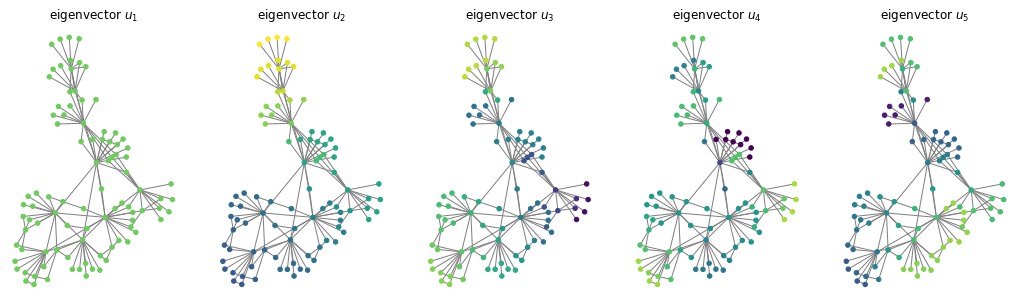

In [153]:
fig, axes = plt.subplots(1, 5, figsize=(18, 5))

U = V

Network1.set_coordinates('spring')
Network1.compute_fourier_basis()

limits = [f(Network1.U[:, :len(axes)]) for f in (np.min, np.max)]

for i, ax in enumerate(axes):
    Network1.plot_signal(Network1.U[:, i], limits=limits, colorbar=False, vertex_size=20, ax=ax)
    ax.set_title(f'eigenvector $u_{i+1}$')
    ax.set_axis_off()

# plt.savefig('U1-7_t443.pdf')

<Figure size 720x1440 with 0 Axes>

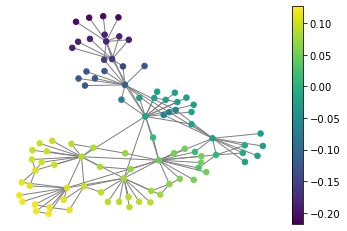

In [154]:
plt.figure(figsize=(10, 20))
Network1.plot_signal(U[:,1], vertex_size=30) # #G_outer1.plot_signal(U[:,0]);
plt.axis('off'); plt.title(''); # plt.savefig('U2_t443.pdf')

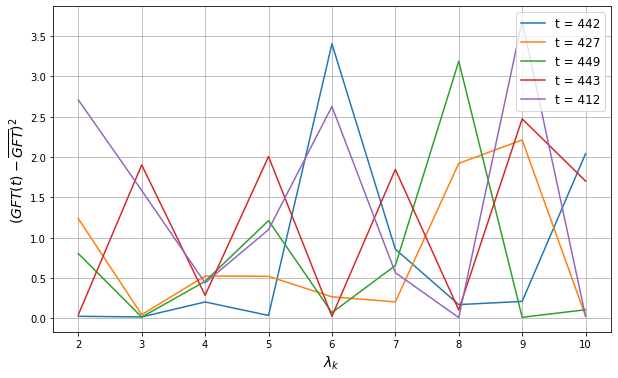

In [28]:
fg, ax = plt.subplots(figsize=(10, 6))
xaxis = [i for i in range(2, 11)]
plt.grid(True)
plt.xlabel('$\lambda_k$',  fontsize=14)
plt.ylabel('$(GFT(t) - \overline{GFT})^2$',  fontsize=14)
for i in samp_discords:
    aux = [(x - y)**2 for x,y in zip(list(mean_gsignal),list(spectra[i:(i + 9)]))]
    ax.plot(xaxis, aux, markersize=4, label='t = ' + str(i) )
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=12)

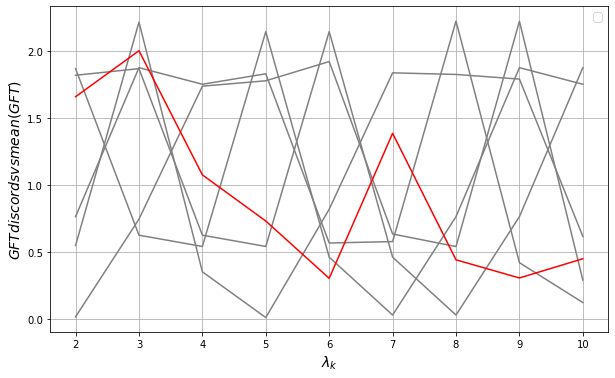

In [30]:
fg, ax = plt.subplots(figsize=(10, 6))
xaxis = [i for i in range(2, 11)]
plt.grid(True)
plt.xlabel('$\lambda_k$',  fontsize=14)
plt.ylabel('$GFT discords vs mean(GFT)$',  fontsize=14)
for i in samp_discords:
    # aux = [(x - y)**2 for x,y in zip(list(mean_gsignal),list(spectra[i:(i + 9)]))]
    ax.plot(xaxis, list(spectra[i:(i + 9)]), markersize=4, color = 'gray') # label='t = ' + str(i) )

ax.plot(xaxis, list(mean_gsignal), markersize=4, color = 'red') 

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=12)